In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import tensorflow as tf

import model
from data_reader import load_data, DataReader
import matplotlib.pyplot as plt


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"


flags = tf.flags

# data
flags.DEFINE_string('load_model',   None,    'filename of the model to load')
# we need data only to compute vocabulary
flags.DEFINE_string('data_dir',   'data',    'data directory')
flags.DEFINE_integer('num_samples', 300, 'how many words to generate')
flags.DEFINE_float('temperature', 1.0, 'sampling temperature')

# model params
flags.DEFINE_integer('rnn_size',        300,                            'size of LSTM internal state')
flags.DEFINE_integer('highway_layers',  2,                              'number of highway layers')
flags.DEFINE_integer('char_embed_size', 32,                             'dimensionality of character embeddings')
flags.DEFINE_string ('kernels',         '[1,2,3,4,5,6,7]',              'CNN kernel widths')
flags.DEFINE_string ('kernel_features', '[50,100,150,200,200,200,200]', 'number of features in the CNN kernel')
flags.DEFINE_integer('rnn_layers',      2,                              'number of layers in the LSTM')
flags.DEFINE_float  ('dropout',         0.5,                            'dropout. 0 = no dropout')

# optimization
flags.DEFINE_integer('max_word_length',     35,   'maximum word length')

# bookkeeping
flags.DEFINE_integer('seed',           3435, 'random number generator seed')
flags.DEFINE_string ('EOS',            '+',  '<EOS> symbol. should be a single unused character (like +) for PTB and blank for others')

FLAGS = flags.FLAGS

In [3]:
def generate():
    ''' Loads trained model and evaluates it on test split '''

    if FLAGS.load_model is None:
        print('Please specify checkpoint file to load model from')
        #FLAGS.load_model =  'cv/epoch024_7.5178.model'
        FLAGS.load_model = 'cv/epoch024_7.5255.model'

    if not os.path.exists(FLAGS.load_model + '.meta'):
        print('Checkpoint file not found', FLAGS.load_model)
        return -1

    word_vocab, char_vocab, word_tensors, char_tensors, max_word_length = \
        load_data(FLAGS.data_dir, FLAGS.max_word_length, eos=FLAGS.EOS)

    print('initialized test dataset reader')

    with tf.Graph().as_default(), tf.Session() as session:

        # tensorflow seed must be inside graph
        tf.set_random_seed(FLAGS.seed)
        np.random.seed(seed=FLAGS.seed)

        ''' build inference graph '''
        with tf.variable_scope("Model"):
            m = model.inference_graph(
                    char_vocab_size=char_vocab.size,
                    word_vocab_size=word_vocab.size,
                    char_embed_size=FLAGS.char_embed_size,
                    batch_size=1,
                    num_highway_layers=FLAGS.highway_layers,
                    num_rnn_layers=FLAGS.rnn_layers,
                    rnn_size=FLAGS.rnn_size,
                    max_word_length=max_word_length,
                    kernels=eval(FLAGS.kernels),
                    kernel_features=eval(FLAGS.kernel_features),
                    num_unroll_steps=1,
                    dropout=0)

            # we need global step only because we want to read it from the model
            global_step = tf.Variable(0, dtype=tf.int32, name='global_step')

        saver = tf.train.Saver()
        saver.restore(session, FLAGS.load_model)
        print('Loaded model from', FLAGS.load_model, 'saved at global step', global_step.eval())

        ''' training starts here '''
        rnn_state = session.run(m.initial_rnn_state)
        logits = np.ones((word_vocab.size,))
        rnn_state = session.run(m.initial_rnn_state)
        outputs_list = []
        output_words = []
        for idx in range(word_vocab.size):
            
            word = word_vocab.token(idx)
            char_input = np.zeros((1, 1, max_word_length))
            for i,c in enumerate('{' + word + '}'):
                char_input[0,0,i] = char_vocab[c]
            
            outputs, logits = session.run([m.rnn_outputs,m.logits],
                                         {m.input: char_input,
                                          m.initial_rnn_state: rnn_state})
            outputs_list.append(outputs)
            output_words.append(word)
            if idx % 1000 == 0:
                print(idx)
        outputs_array = np.array(outputs_list).squeeze()
        print(outputs_array.shape)
        
        return outputs_array, output_words


In [4]:
word_vocab, char_vocab, _, _, _ = \
        load_data('data', 35, eos='+')

reading train
reading valid
reading test

actual longest token length is: 34
size of word vocabulary: 56938
size of char vocabulary: 63
number of tokens in train: 259760
number of tokens in valid: 67092
number of tokens in test: 82430


bir


In [7]:
output_array, words = generate()

Please specify checkpoint file to load model from
reading train
reading valid
reading test

actual longest token length is: 34
size of word vocabulary: 56938
size of char vocabulary: 63
number of tokens in train: 259760
number of tokens in valid: 67092
number of tokens in test: 82430
initialized test dataset reader
INFO:tensorflow:Restoring parameters from cv/epoch024_7.5255.model
Loaded model from cv/epoch024_7.5255.model saved at global step 9275
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
(56938, 300)


In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
low_dim = pca.fit_transform(output_array)

In [9]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=2, perplexity=30.0).fit_transform(low_dim[0:2000,:])
X_embedded.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.684164
[t-SNE] Iteration 25: error = 1.8199081, gradient norm = 0.0061491
[t-SNE] Iteration 50: error = 1.6244198, gradient norm = 0.0045467
[t-SNE] Iteration 75: error = 1.1548514, gradient norm = 0.0017979
[t-SNE] Iteration 100: error = 1.0845852, gradient norm = 0.0014966
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.084585
[t-SNE] Iteration 125: error = 0.9839770, gradient norm = 0.0011116
[t-SNE] Iteration 150: error = 0.9552646, gradient norm = 0.0010160
[t-SNE] Iteration 175: error = 0.9482971, gradient norm = 0.0009922
[t-SNE] Iteration 175: gradient norm 0.000992. Finished.
[t-SNE] Error after 175 iterations: 1.084585


(2000, 2)

In [56]:
np.savez('wembeddings300.npz', output_array)

In [ ]:
print(low_dim.shape)

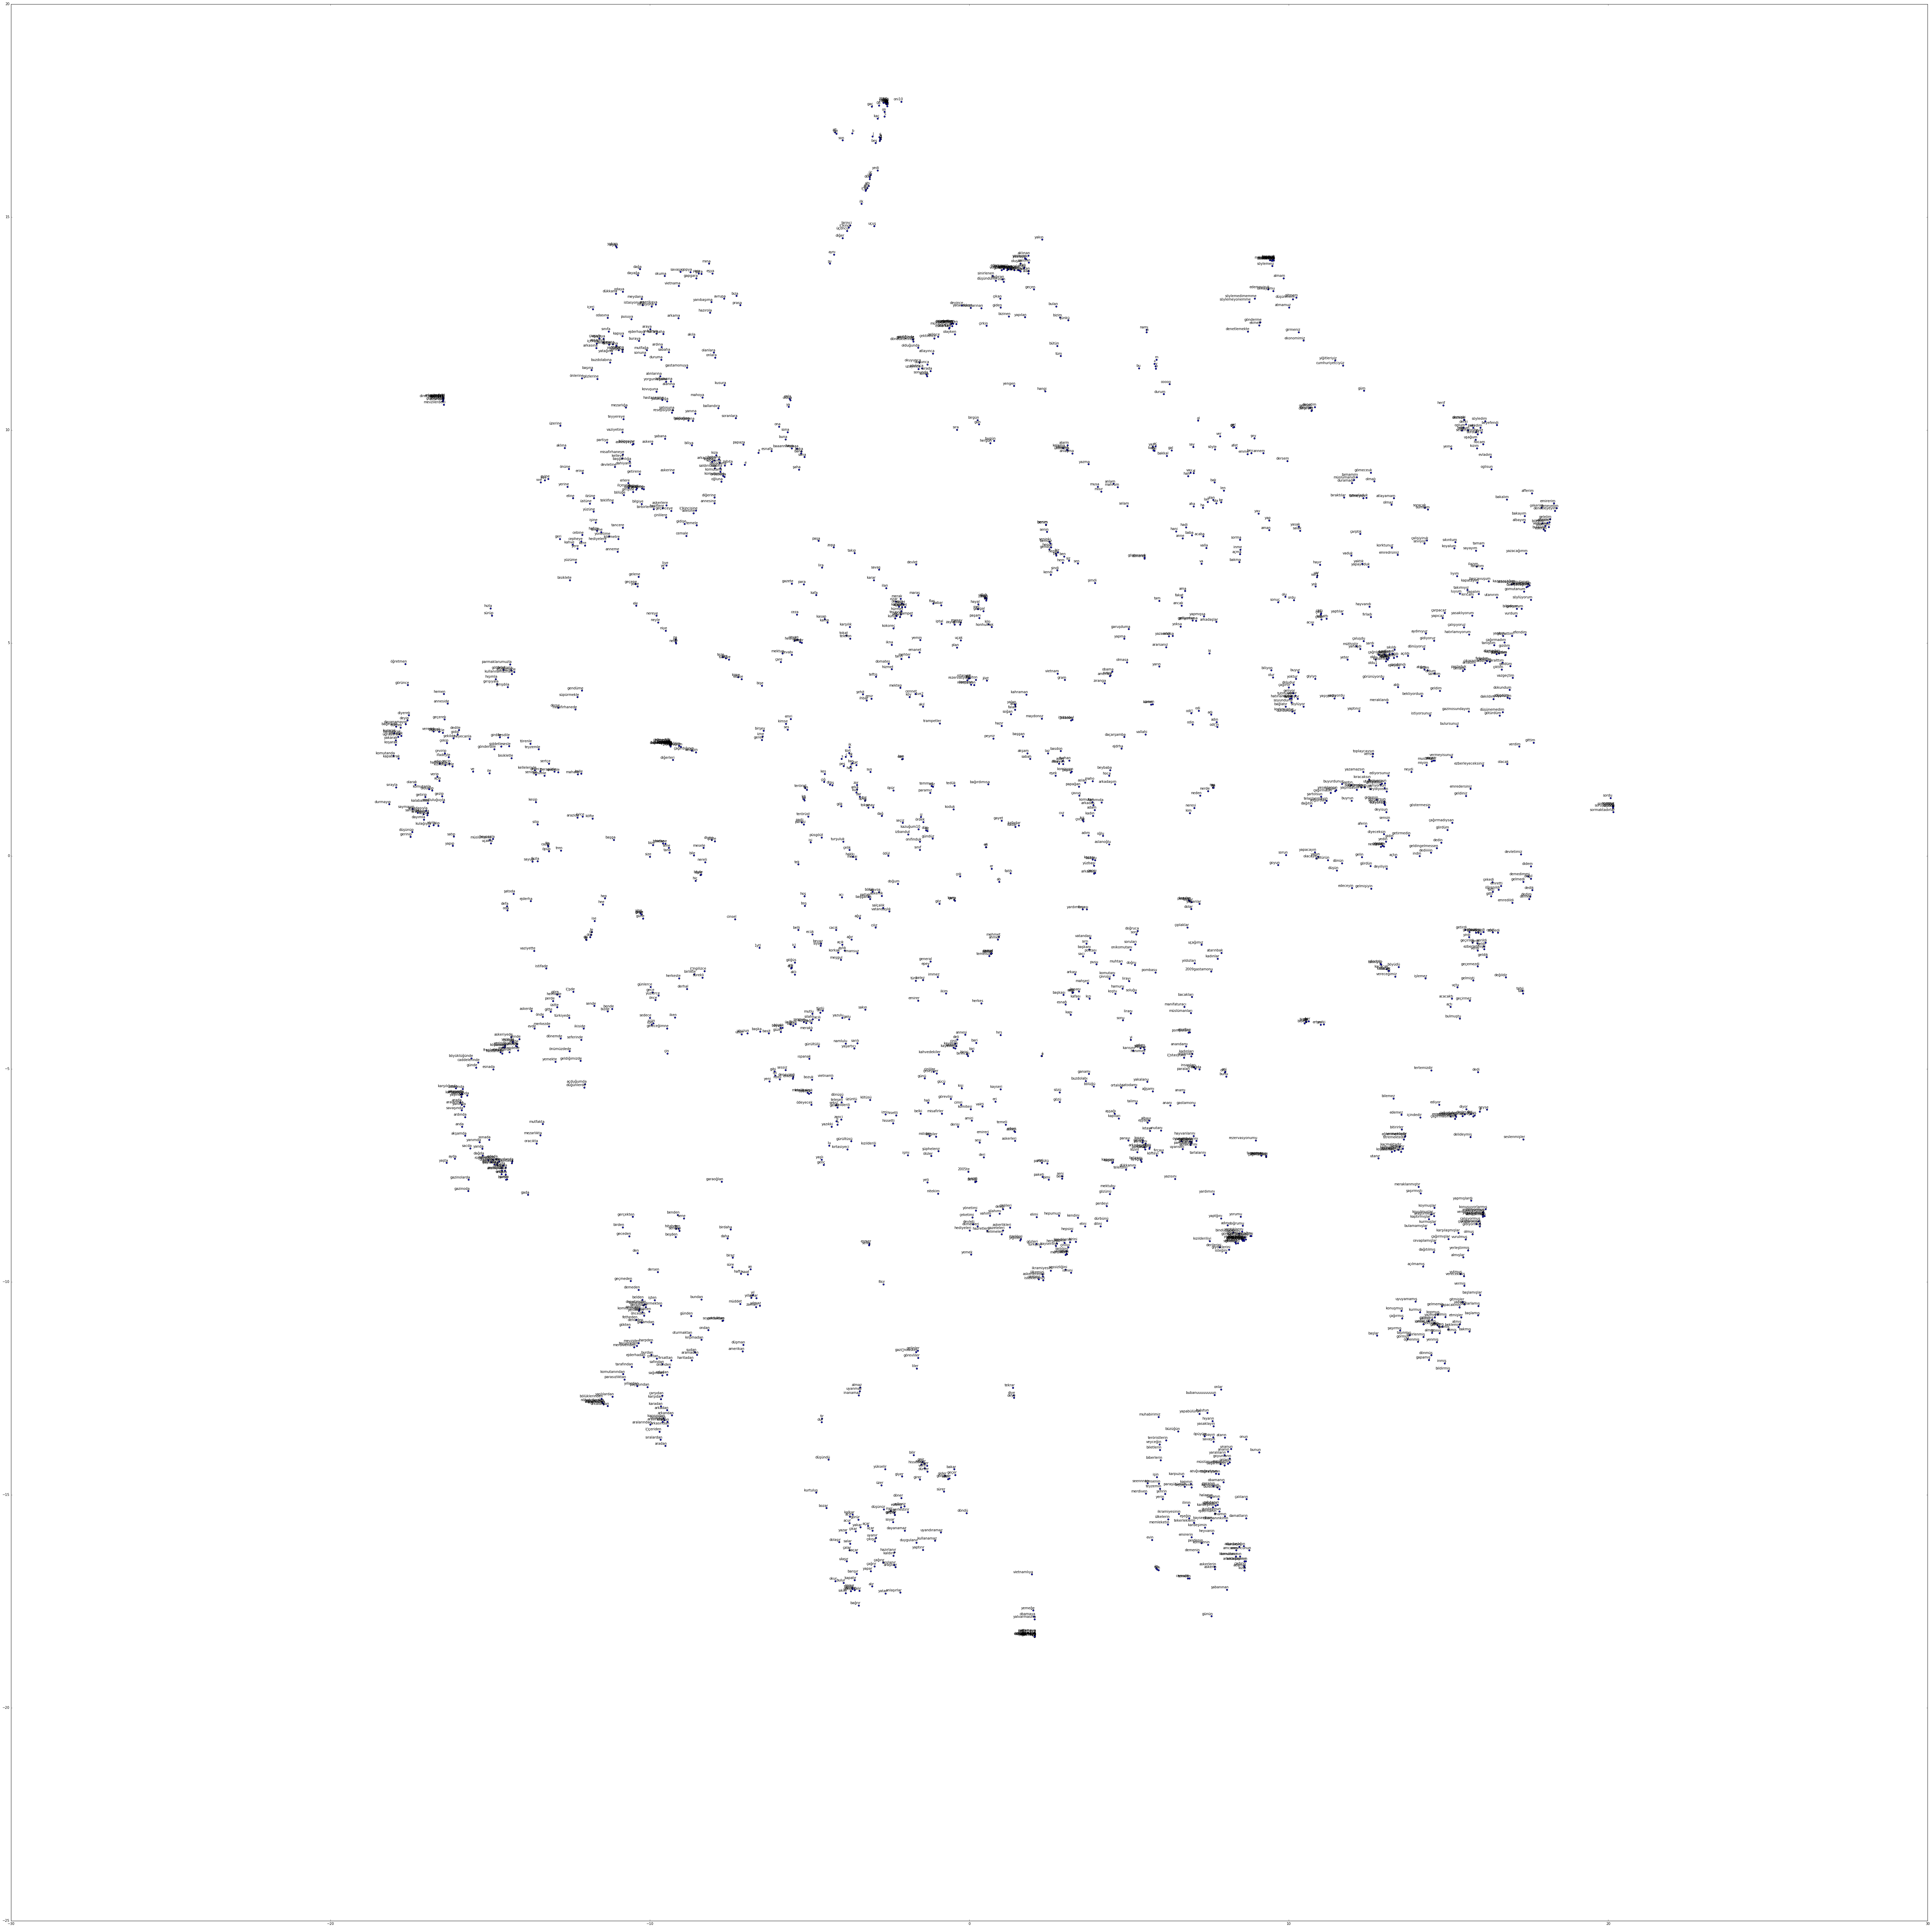

In [10]:

x = X_embedded[:,0]
y = X_embedded[:,1]
labels = words
plt.figure(figsize=(100, 100)) 
for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [52]:
diff = output_array[words.index('merdiveni'),:]/output_array[words.index('merdiven'),:]*output_array[words.index('temel'),:]

In [53]:
diff_a = output_array/diff
diff_a = np.linalg.norm(diff_a,axis=1)
sorted_a = np.argsort(diff_a)

In [55]:
for i in range(5):
    print(words[sorted_a[i]])

fadime
fadume
kardeşe
komiser
doctors


In [57]:
import keras

Using TensorFlow backend.
